**Oreum Industries Internal Project, 2024Q3**

---

# 100_Exponential_Univariate.ipynb

### Survival Regression Demo in `oreum_survival`

Demonstrate Survival Regression Modelling using Bayesian inference and a 
Bayesian workflow, specifically using the `pymc` & `arviz` ecosystem.

In this __10x_Exponential family__  series of notebooks we demonstrate the theory and 
usage of **Exponential** models with univariate, parametric and semi-parametric architectures.
These are the general baseline concepts from which we later develop more advanced survival models.

**In this Notebook:**

+ We extend our basic understanding with worked examples of parametric and semi-parametric models in the Exponential
architecture family, using our real-world observational censored dataset.
+ Specifically **A Parametric Univariate Model: Constant Hazard**


## Contents

+ [Setup](#Setup)

+ [0. Load Dataset](#0.-Load-Dataset)

+ [1. Model Description](#1.-Model-Description)

+ [2. Packaged Frequentist Model `ExponentialFitter`](#2.-Packaged-Frequentist-Model-`ExponentialFitter`)

+ [3. Custom Bayesian Model `ExponentialUnivariate`](#3.-Custom-Bayesian-Model-`ExponentialUnivariate`)
---


# Setup

## Imports

In [ ]:
import sys
from pathlib import Path

import lifelines as sa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from oreum_core import curate, eda
from oreum_core import model_pymc as mt
from pyprojroot.here import here
from scipy import stats

# prepend local project src files
module_path = here('src').resolve(strict=True)
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))

from engine import logger, utils
from model import exponential

import warnings  # isort:skip # suppress seaborn, it's far too chatty

warnings.simplefilter(action='ignore', category=FutureWarning)  # isort:skip
import seaborn as sns

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/pymc/util.py:38: FutureWarning: dataset_to_point_list has been moved to backends.arviz. Importing from util will fail in a future release.
  warnings.warn(


##### Notebook config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

log = logger.get_logger('100_Exponential_Univariate', notebook=True)
_ = logger.get_logger('oreum_core', notebook=True)

## Local Functions and Global Vars

In [3]:
LOAD_FROM_CSV = True
RNG = np.random.default_rng(seed=42)

## Data Connections and Helper Objects

In [4]:
csvio = curate.PandasCSVIO(here(Path('data', 'raw', 'verbatim')).resolve(strict=True))
ppqio = curate.PandasParquetIO(here(Path('data', 'prepared')).resolve(strict=True))
mdlio = mt.PYMCIO(here(Path('data', 'models')).resolve(strict=True))
figio = eda.FigureIO(here(Path('plots')).resolve(strict=True))

---

---

# 0. Load Dataset

In [5]:
dfr = csvio.read(fn='mastectomy', index_col='rowid')
eda.display_ht(dfr)

,time,event,metastized
rowid,,,
0,23,True,no
1,47,True,no
2,69,True,no
41,212,False,yes
42,217,False,yes
43,225,False,yes


'Shape: (44, 3), Memsize 0.0 MB'

##### Correct dtypes etc

In [6]:
df = dfr.copy()
df['pid'] = ['p{}'.format(x) for x in range(len(df))]
df = df.reset_index(drop=True).set_index('pid')
df.rename(columns={'time': 'duration', 'event': 'death', 'metastized': 'met'}, inplace=True)
df['death'] = df['death'].astype(bool)
df['met'] = df['met'].apply(lambda x: True if str(x).strip() == 'yes' else False)
eda.describe(df)

,28,3,33,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p28,p3,p33,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,68,70,109,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death,True,False,False,bool,0,NaN,NaN,2,True,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
met,True,False,True,bool,0,NaN,NaN,2,True,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Shape: (44, 4), Memsize 0.0 MB'

---

---

# 1. Model Description

## 1.1 Creating the constant hazard aka Exponential model

The observational estimators shown in `000_Intro.ipynb` (Kaplan-Meier, Nelson-Aalen) are useful, but we want to create a 
model that's not just a summary of a dataset, but instead abstracts patterns into **parametric values** that we can use
to infer relationships on existing data and predict patterns on new as-yet-unseen data.

We will start by estimating the **hazard function** $\lambda(t)$ as a constant 
value $\gamma \in (0, \infty)$ for all observed times. In our brief explanation
we assume no censoring, and that it integrates to infinity as required for a 
self-consistent survival model. This yields the **cumulative hazard function** 
$\Lambda(t)$ and **survival function** $S(t)$ as:

$$
\begin{align}
\hat \lambda(t) &= \gamma\\
\text{...so:} \\
\hat \Lambda(t) &= \gamma t \\
\text{...and:} \\
\hat S(t) &= \exp(-\Lambda(t)) \\
          &= \exp(-\gamma t) \\
\end{align}
$$

The **event density function** $\pi(t)$ aka the time-to-event or survival 
duration as shown above (Section 1.3) is then:

$$
\begin{align}
\pi(t) &= \lambda(t) \cdot S(t) \\
       &= \gamma \cdot \exp(-\gamma t) \\
\end{align}
$$

**IMPORTANT OBSERVATION:**
+ This is exactly the PDF of the exponential distribution: $\pi(t) \sim \text{Exponential}(t\ |\ \gamma)$, so this is called the **Exponential model**
+ $\pi$ is [Exponential](https://en.wikipedia.org/wiki/Exponential_distribution): the duration between events that occur
  continuously and independently at a constant average rate
+ This brings helpful shortcut summary statistics such as:
  $\mathbb{E}(\pi) = \frac{1}{\lambda}$ and $\mathbb{V}(\pi) = \frac{1}{\lambda^{2}}$ etc

## 1.2 Estimating $\pi$

We can directly estimate $\gamma$ from our observational values $\pi(t)$ 
(in our dataset this is labelled `duration`) by fitting the log-likelihood 
$\log \mathcal{L}$ of $\pi$ as:

$$
\begin{align}
\log \mathcal{L}\ \pi(t) &\sim \log \big( \gamma \cdot \exp(-\gamma t) \big) \\
                        &\sim \log \gamma - \sum_{i}\gamma t_{i} \\
\end{align}
$$

This initial formulation doesn't allow for censoring, and we can see the
component $\log \gamma$ would contribute too much to the log-likelihood by 
including observations where the duration is not due to a death event.

See `000_Intro.ipynb` $\S2.4$ for details on censoring

Again we modify the log-likelihood with an indicator variable $d_{i}$ where 
$d \in \{0, 1\}$ to effectively ignore non-death censorings (where $d = 0$):

$$
\begin{align}
\log \mathcal{L}\ \pi(t) &\sim \sum_{i} d_{i} \log \gamma - \gamma t_{i} \\
\end{align}
$$


We will estimate $\log \mathcal{L}\ \pi(t)$ using a prepackaged Frequentist 
model for comparison, then build a custom Bayesian model, justified due to the 
many reasons noted above in [Preamble - Why Bayes?](#Preamble---Why-Bayes?)

## 1.3 Illustration of functions to aid intuition

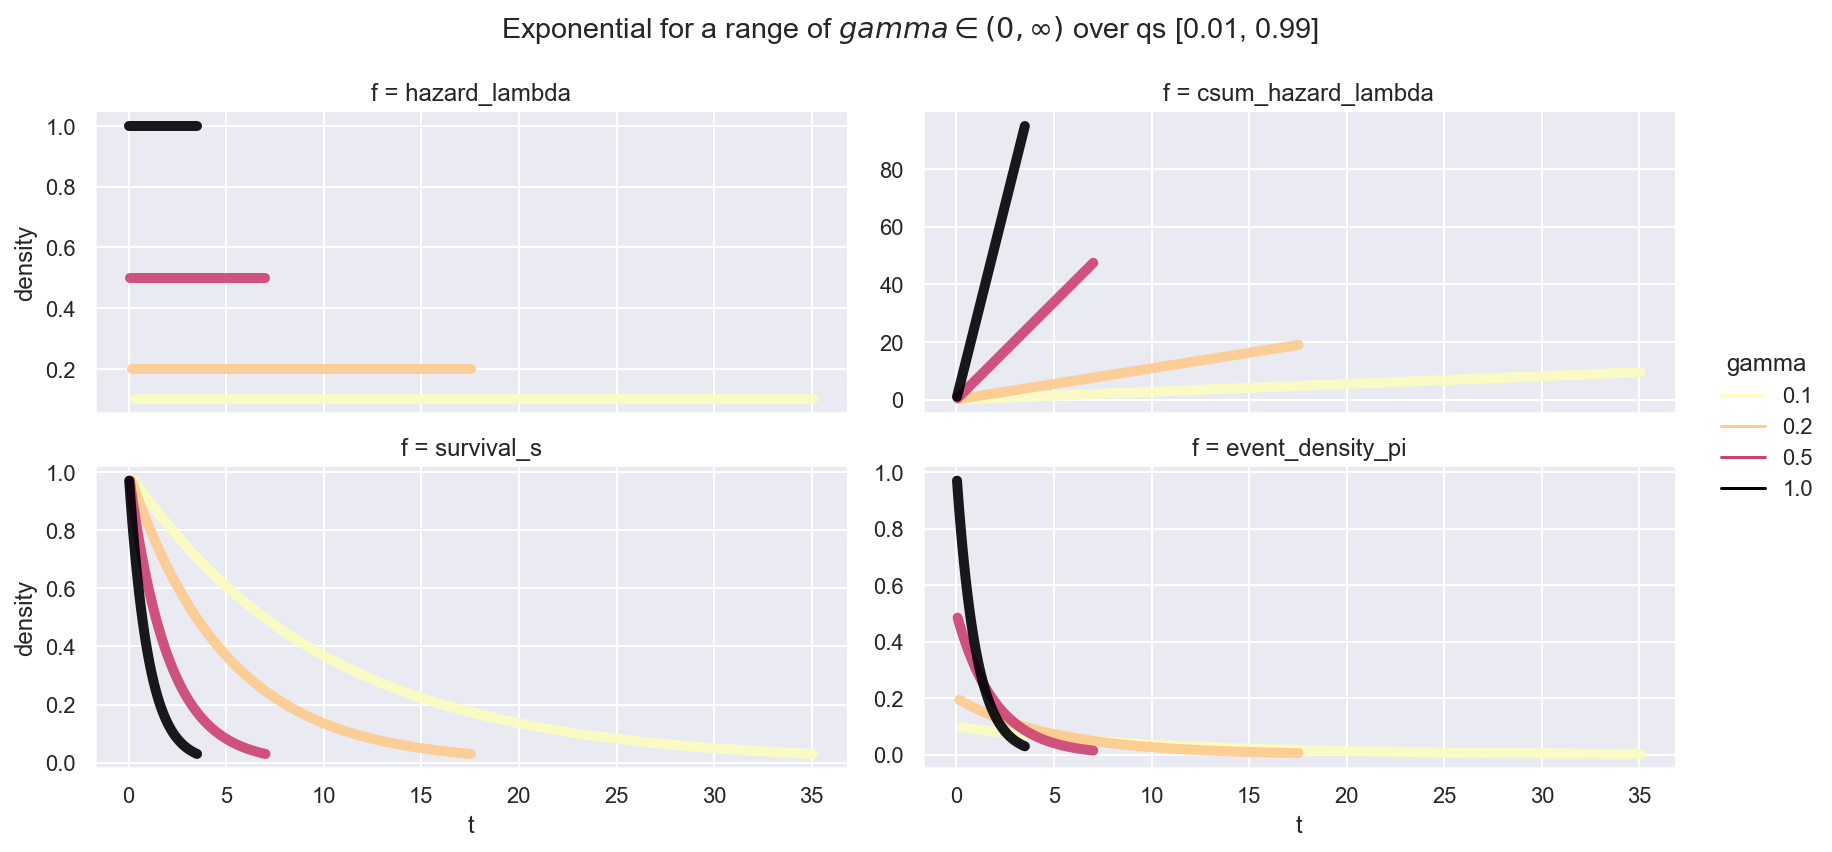

In [7]:
gammas = [0.1, 0.2, 0.5, 1]
dff = pd.concat([utils.get_fs(stats.expon(loc=0, scale=1/g), {'gamma': g}) for g in gammas])
_ = utils.plot_f(dff, 'Exponential', 'gamma')

## 1.4 Digression on semi-parametric regression extensions of $\lambda(t) = \gamma$

Without getting any more complicated (see $\S1.0.5$ Non-constant Hazard Functions), we can already note there's an infinite 
number of ways to create a single, constant valued $\lambda(t) = \gamma$. The 2 major methods are:

+ Parametric Regression, e.g.: $\lambda(t)_{i} = \gamma_{i} = \exp (\beta^{T} \mathbf{x}_{i})$
+ Semi-Parametric Regression, e.g: $\lambda(t)_{i} = \gamma_{i} = \lambda_{0}(t) \exp(\beta^{T}\mathbf{x}_{i})$

Where:

+ $\exp (\beta^{T} \mathbf{x}_{i})$ is a log-linear regression onto features $\mathbf{x}_{i}$ of individual $i$,
+ $\lambda_{0}(t)$ is a baseline hazard

In other words, the constant hazard (aka Exponential model) is unusual because it lends itself to both model formats:

+ Exponential Parametric Regression -> this can also be called an **Accelerated Failure Time model** (see $\S2$, and `002_AFT.ipynb`)
+ Exponential Semi-Parametric (Piecewise) Regression -> this is the **Cox Proportional Hazards model** (see $\S3$, and `003_Piecewise.ipynb`)



## 1.5 Digression on non-constant hazard functions

We can of course choose any reasonable function $f(t)$ for $\lambda(t)$ so long
as it obeys the range $[0, \infty)$:

$$
\begin{align}
\hat \lambda(t) &= f(t)\\
\hat \Lambda(t) &= \int_{0}^{t} dt f(t) \\
\hat S(t) &= \exp(-\Lambda(t)) \\
\pi(t) &= \lambda(t) \cdot \exp(-\Lambda(t)) \\
\log \mathcal{L}\ \pi(t) &= \log \lambda(t) - \Lambda(t) \\
\end{align}
$$

Again note the Exponential model is where $\pi(t) \sim \text{Exponential}(t\ |\ \gamma)$ which is produced because 
$\lambda = f(t) = \gamma$, a constant value. 

This notebook focusses on 3 different ways to construct that value $\pi$: 
as a scalar, as a full regression, as a semi-parametric (piecewise) regression

More interesting functions $f(t)$ appear throughout the literature, often dogmatically associated with specific domains.
We remind again that the parametric form is only ever a convenient approximation of the real-world data generating 
process, and so we must avoid bold statements like "human lifespan has a Gompertz function". 

The functions $f(t)$ also usually appear as part of an "Accelerated Failure Time (AFT)" model, which as we note above, 
is just a regression onto individual features. The Exponential Parametric Regression model is the simplest example of an
Accelerated Failure Time model (see $\S2$ below).

---

---

# 2. Packaged Frequentist Model `ExponentialFitter`

## 2.1 Fit Model

To make life easier, and give us something to compare to, let's start with the frequentist pre-packaged library model in `lifelines` which fits $\log\mathcal{L}$ via optimization using `L-BFGS-B`

In [8]:
ex = sa.ExponentialFitter(alpha=0.06)
ex.fit(durations=df['duration'], event_observed=df['death'] * 1, show_progress=False)
ex.print_summary()

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 44 total observations, 18 right-censored observations>
   number of observations = 44
number of events observed = 26
           log-likelihood = -158.52
               hypothesis = lambda_ != 0

---
          coef  se(coef)  coef lower 94%  coef upper 94%
lambda_ 163.50     32.06          103.19          223.81

         cmp to    z      p  -log2(p)
lambda_    0.00 5.10 <0.005     21.48
---
AIC = 319.03

## 2.2 View fitted values

In [9]:
ci_vals = ex.confidence_interval_hazard_.iloc[0].values
gamma_est = np.array([ci_vals[0], 1 / ex.lambda_, ci_vals[1]])
gamma_est

array([0.00386022, 0.00611621, 0.0083722 ])

**Observe:**

+ Lifelines uses different notation where, "`lambda_`" is not used for the 
  hazard function (for which they use "`h`"), instead: `lambda_ = 1 / gamma`
+ So this Exponential model estimates the constant **hazard function** $\gamma \sim 0.0061 \in [0.0038, 0.0084]_{CI94}$
+ Note the wide CI94, indicating that a constant hazard is unlikely to be a good assumption

#### Plot Exponential vs Kaplan Meier

In [10]:
km = sa.KaplanMeierFitter(alpha=0.05)
km.fit(durations=df['duration'], event_observed=df['death'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 44 total observations, 18 right-censored observations>

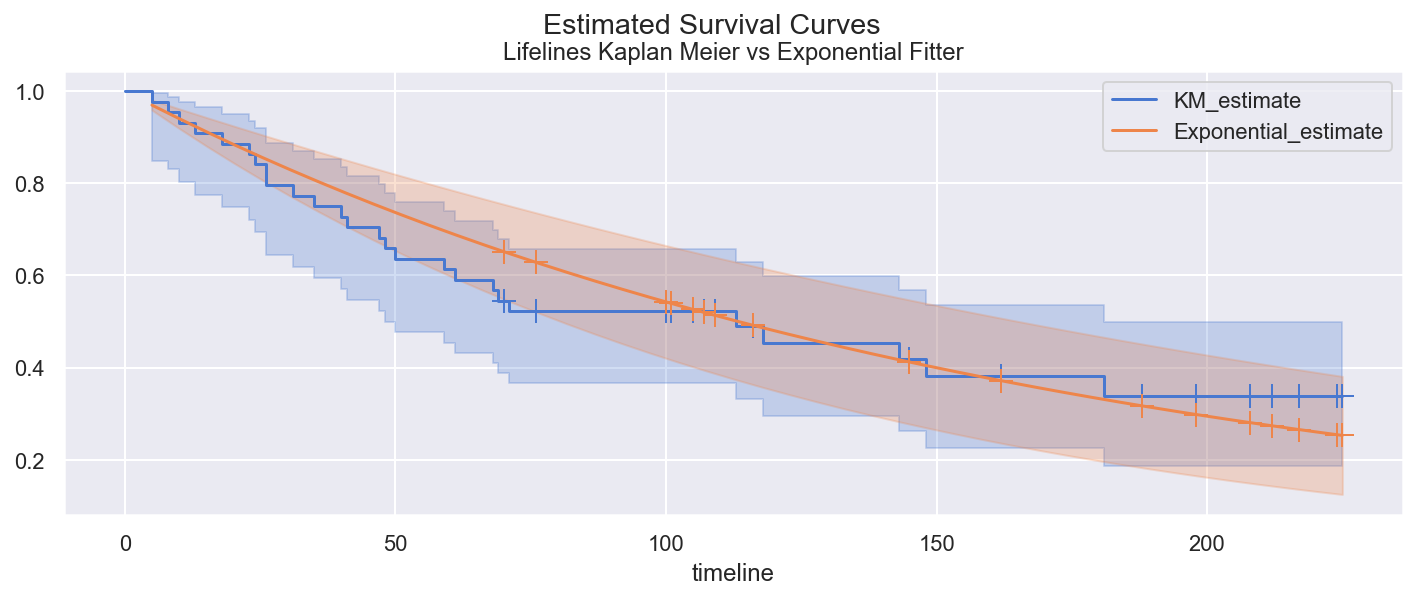

In [11]:
f, axs = plt.subplots(1, 1, figsize=(12, 4), sharey=True, sharex=True)
ax0 = km.plot_survival_function(ax=axs, show_censors=True)
ax1 = ex.plot_survival_function(ax=axs, show_censors=True, color='C1')
_ = ax0.set_title('Lifelines Kaplan Meier vs Exponential Fitter')
_ = f.suptitle('Estimated Survival Curves')

**Observe:**

+ Interesting differences! Clearly the (parametric) Exponential fitter is only
  an approximation of the empirical (non-parametric) Kaplan-Meier fitter - which
  as we know just deterministically plots the observed data (no modelling)
+ The Exponential model overestimates survival in the early durations, and
  underestimates in the later durations, meeting the Kaplan Meier around the
  expected value (mean) toward the middle of the observations. This is no 
  surprise, since we didn't weight the observations, and the expected values 
  should agree
+ The Exponential model assumes constant **hazard function**, which we know is
  unlikely to fit the data perfectly, given the time-varying hazard function
  that we see in the Nelson-Aalen model above
+ Still, there are useful areas of overlap, and as a parametric model, we can
  extrapolate useful summary statistics

#### View medians

In [12]:
med = km.median_survival_time_
mn = np.trapz(y=km.survival_function_.values.flatten(), x=km.survival_function_.index)
print(f'KM: med: {med:.1f}, mean: {mn:.1f}')

med = ex.median_survival_time_
mn = np.trapz(y=ex.survival_function_.values.flatten(), x=ex.survival_function_.index)
print(f'EX: med: {med:.1f}, mean: {mn:.1f}')

KM: med: 113.0, mean: 118.2
EX: med: 113.3, mean: 117.3


**Observe:**

+ Very similar summary stats of the mean and median survival time

---

---

# 3. Custom Bayesian Model `ExponentialUnivariate`

This is the first of many Bayesian models that we will create in this project. Refer to `000_Intro.ipynb` $\S \text{Preamble}$
for the myriad reasons this is a better general method to use.

## 3.0 Prepare & Transform Dataset for Linear Model

This is a preparatory step to transform the observational data into a form for
use in the custom Bayesian models. We will use this transformed dataset `dfx` 
in all subsequent models where possible

NOTE:

+ For this example Notebook we will _not_ partition into train & holdout sets
  (see `README.md ## 5. Data Standards` for terminology)
+ Instead we will simply fit the entire dataset and evaluate in-sample using
  Pareto-smoothed Leave-One-Out (LOO-PIT) cross-validation testing
+ This means we still follow our standard process for preparation, 
  transformation, standardization, but abbreviate to `dfa` only


In-house preferred process (transformation, standardization) to create `dfx` for model usage 

In [13]:
dfx_creator = utils.ProjectDFXCreator()
dfx = dfx_creator.get_dfx(df)
eda.describe(dfx)

,3,30,36,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p3,p30,p36,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,70,76,118,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death_t_true,0,0,1,int64,0,0.0,18.0,NaN,NaN,NaN,26.0,0.59,0.5,0.0,0.0,1.0,1.0,1.0
intercept,1.0,1.0,1.0,float64,0,0.0,0.0,NaN,NaN,NaN,44.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
met_t_true,0,1,1,int64,0,0.0,12.0,NaN,NaN,NaN,32.0,0.73,0.45,0.0,0.0,1.0,1.0,1.0


'Shape: (44, 5), Memsize 0.0 MB'

## 3.1 Build Model Object

`ExponentialUnivariate` model imported from `src.model.exponential.py` where it is fully defined

In [14]:
mdl_eu = exponential.ExponentialUnivariate(obs=dfx, fts_en=dfx_creator.fts_en, 
                                        factor_map=dfx_creator.factor_map, obs_nm='dfx')
mdl_eu.build()
utils.display_rvs(mdl_eu)
mdl_eu.debug()

'RVs for exponential_univariate, v1.0.2, dfx'

gamma ~ Gamma(2, f())

shat ~ Deterministic(f(gamma))

point={'gamma_log__': array(-5.29831739)}

No problems found
point={'gamma_log__': array(-5.29831739)}

No problems found


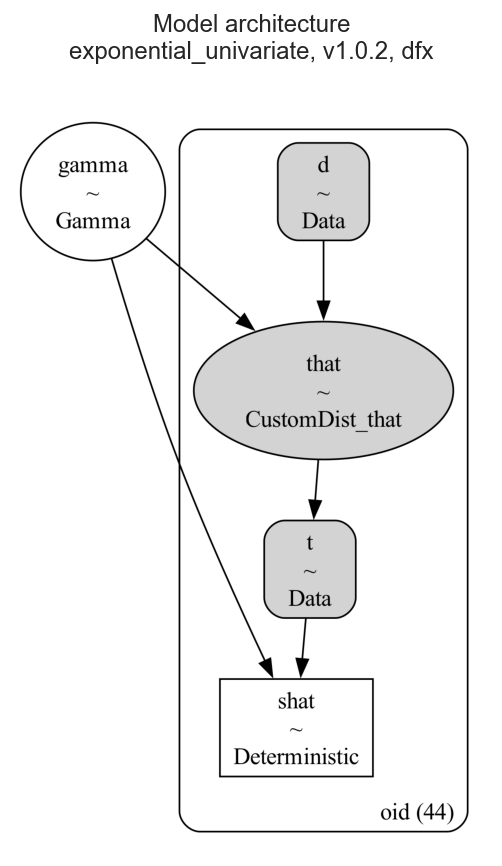

In [15]:
fqn = mdlio.write_graph(mdl_eu)  # output model graph to prove built
f = figio.read(fqn=fqn, title=f'Model architecture\n{mdl_eu.mdl_id}', figsize=(12, 6))

## 3.2 Sample Prior Predictive, View Diagnostics

In [16]:
mdl_eu.sample_prior_predictive(var_names=mdl_eu.rvs_g + mdl_eu.rvs_ppc, replace=True)

#### Evaluate PPC vs In-Sample Data

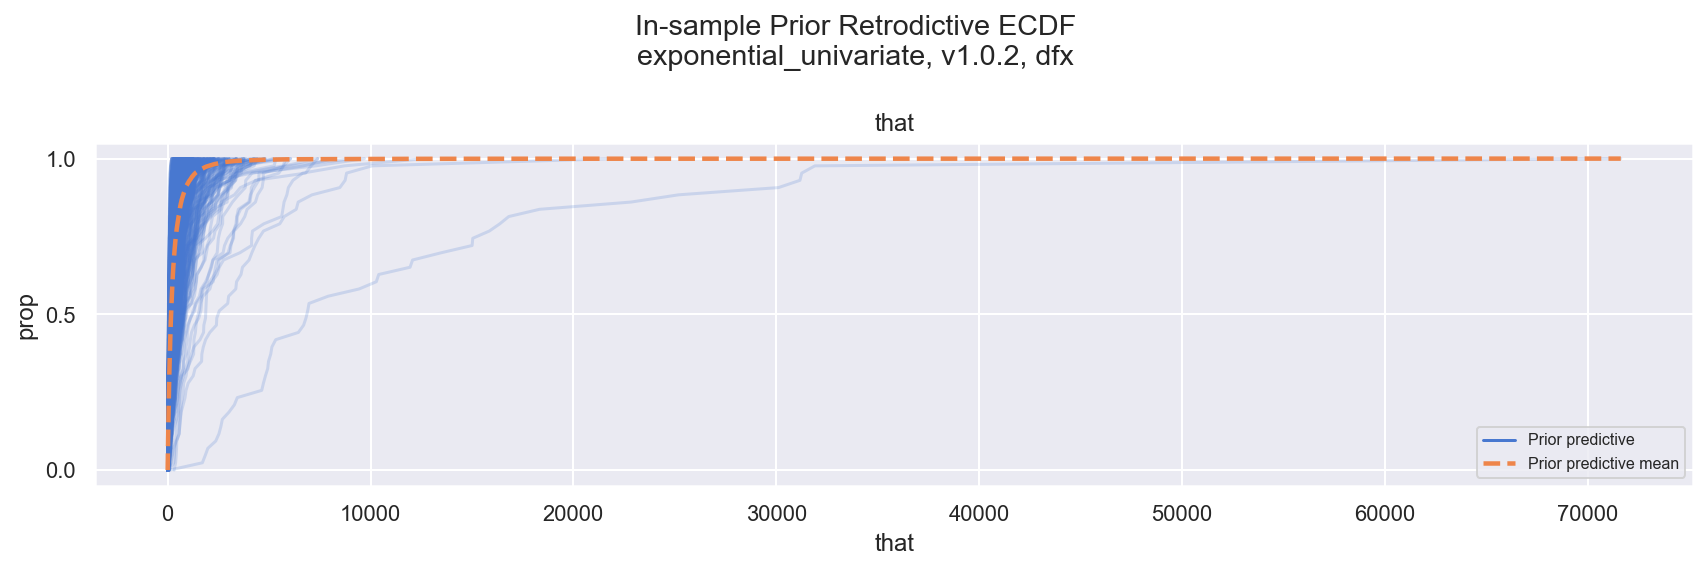

In [17]:
GRP = 'prior'
f = mt.plot_ppc(mdl=mdl_eu, group=GRP, var_names=['that'], insamp=True)

**Observe:**

+ Terrible fit as expected, but the range is valid

#### Evaluate priors and hyperpriors

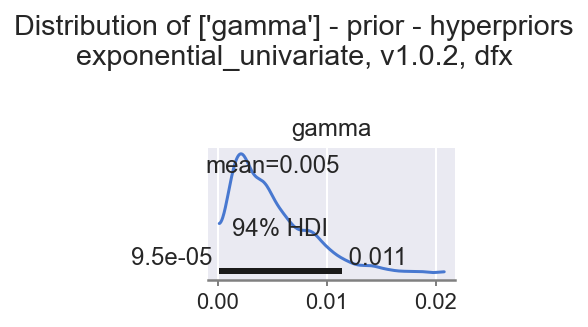

In [18]:
f = mt.facetplot_krushke(mdl=mdl_eu, group=GRP, txtadd='hyperpriors', rvs=mdl_eu.rvs_g)

**Observe:**

+ We've located the prior **hazard function** $\gamma \sim 0.005 \in [9.5e^{-5}, 0.011]_{HDI94}$
  which is a wide range and includes the KM estimate of $\gamma \sim 0.003$
+ There's non-zero mass as high as $0.021$ which at the outer limit of our
  observed durations $t=225$ would yield 
  $\hat{S} = \exp(-\gamma t) = \exp(-0.021 * 225) = 0.009$, practically zero, so 
  this prior can deliver the full span of $\hat{S} \in [0, 1]$.

## 3.3 Sample Posterior, View Diagnostics

In [19]:
mdl_eu.sample(progressbar=True)
mdl_eu.sample_posterior_predictive(store_ppc=True, ppc_insample=True, var_names=mdl_eu.rvs_ppc)
mdlio.write_idata(mdl=mdl_eu)

Output()

Output()

PosixPath('/Users/jon/workspace/oreum/oreum_survival/data/models/idata_exponential_univariate_v102_dfx.netcdf')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma,0.006,0.001,0.004,0.008,0.0,0.0,862.0,1341.0,1.0


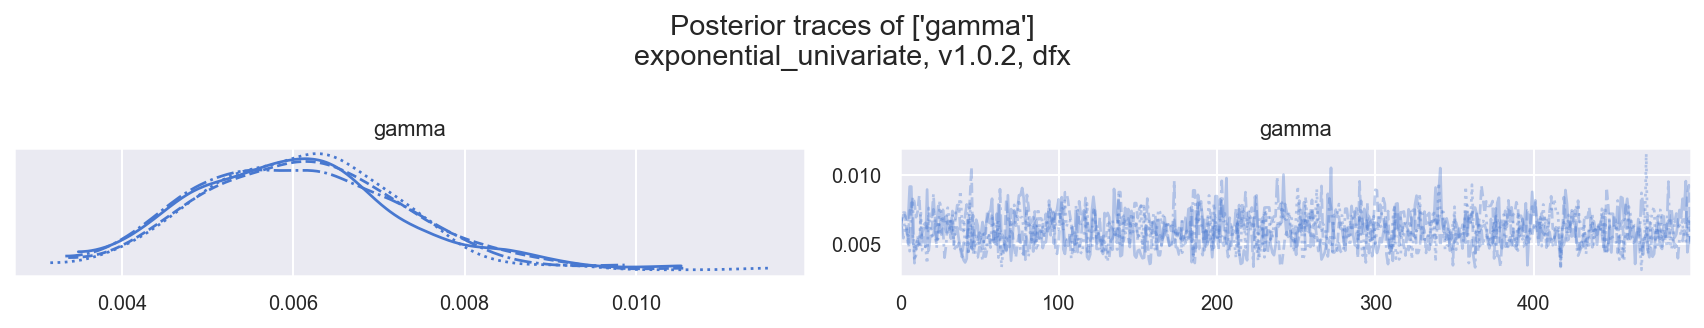

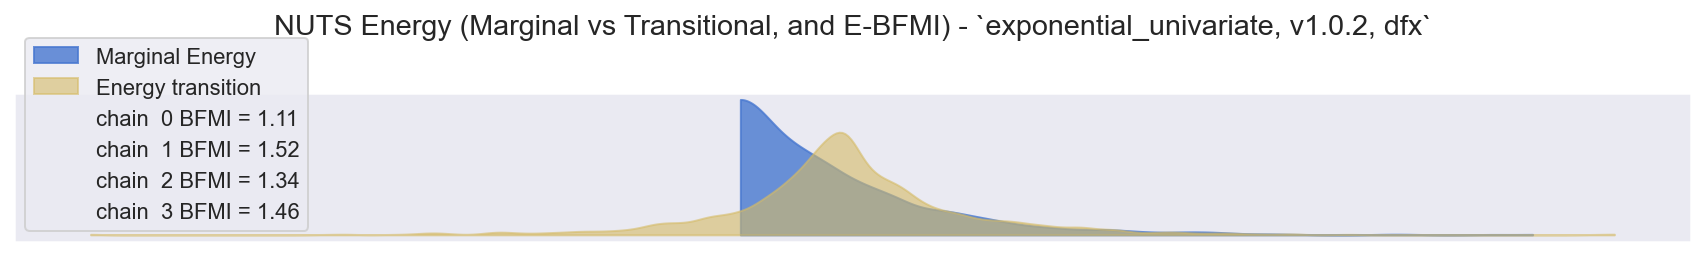

In [20]:
f = mt.plot_trace(mdl=mdl_eu, rvs=mdl_eu.rvs_g, kind='trace')
f = mt.plot_energy(mdl=mdl_eu)
smry = mt.get_summary(mdl=mdl_eu, rvs=mdl_eu.rvs_g)
smry

**Observe:**

+ Posterior distributions reasonably smooth and central
+ Samples well-mixed and well-behaved: `ess_bulk` is good, `r_hat` is good
+ Marginal energy | energy transition looks okay: `E-BFMI > 0.3` so [apparently reasonable](https://python.arviz.org/en/stable/api/generated/arviz.bfmi.html#arviz.bfmi)

## 3.4 Evaluate Posterior PPC (In-Sample)

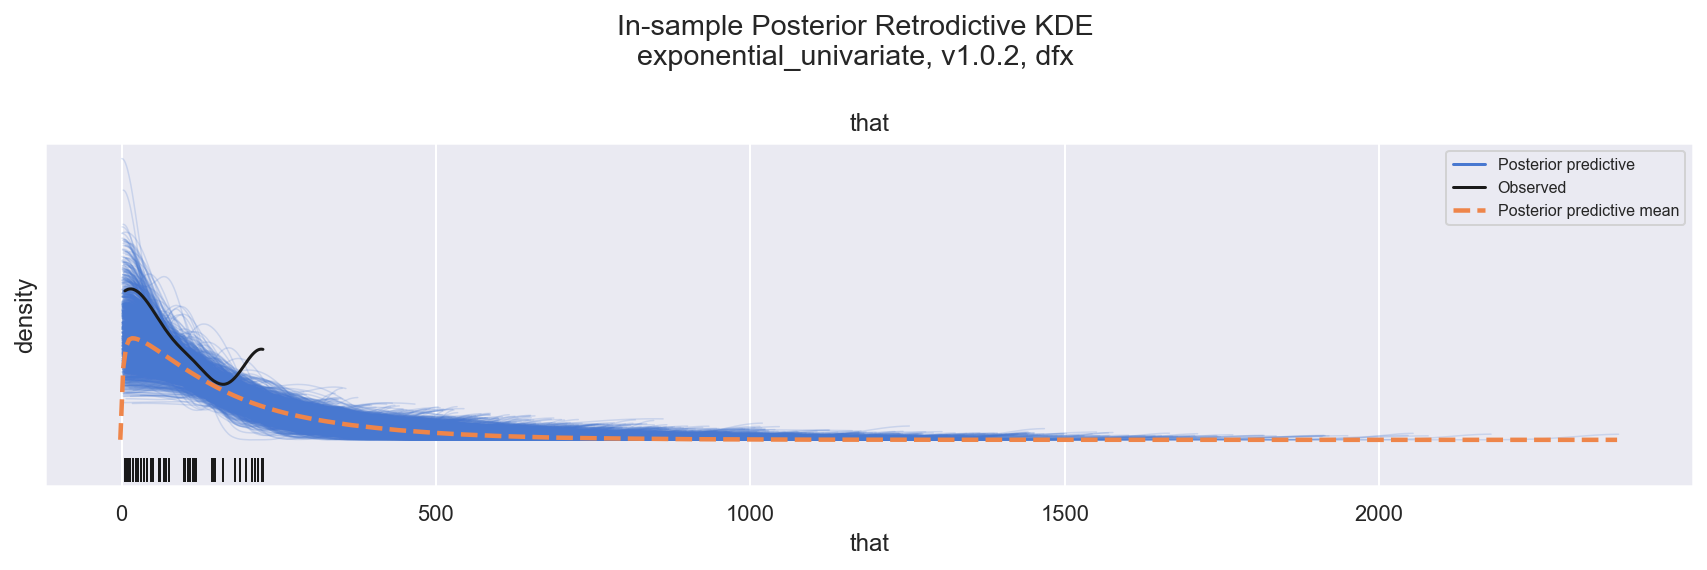

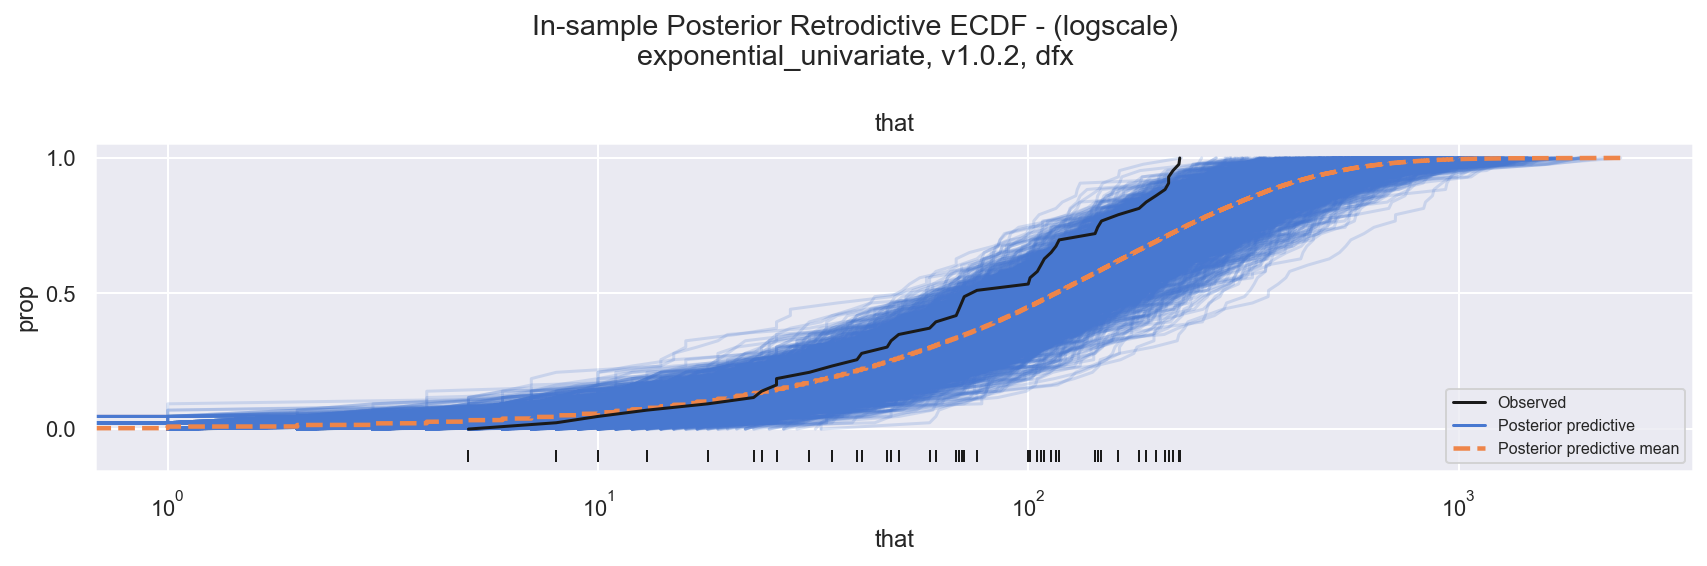

In [21]:
GRP = 'posterior'
f = mt.plot_ppc(mdl=mdl_eu, group=GRP, var_names=['that'], ecdf=False, insamp=True)
f = mt.plot_ppc(mdl=mdl_eu, group=GRP, var_names=['that'], insamp=True, logx=True)

**Observe:**

+ We have an approximate fit, but it's pretty extended to the right of the cumulative observations (overdispersed) - room to improve!

## 3.5 Evaluate LOO-PIT (In-Sample)

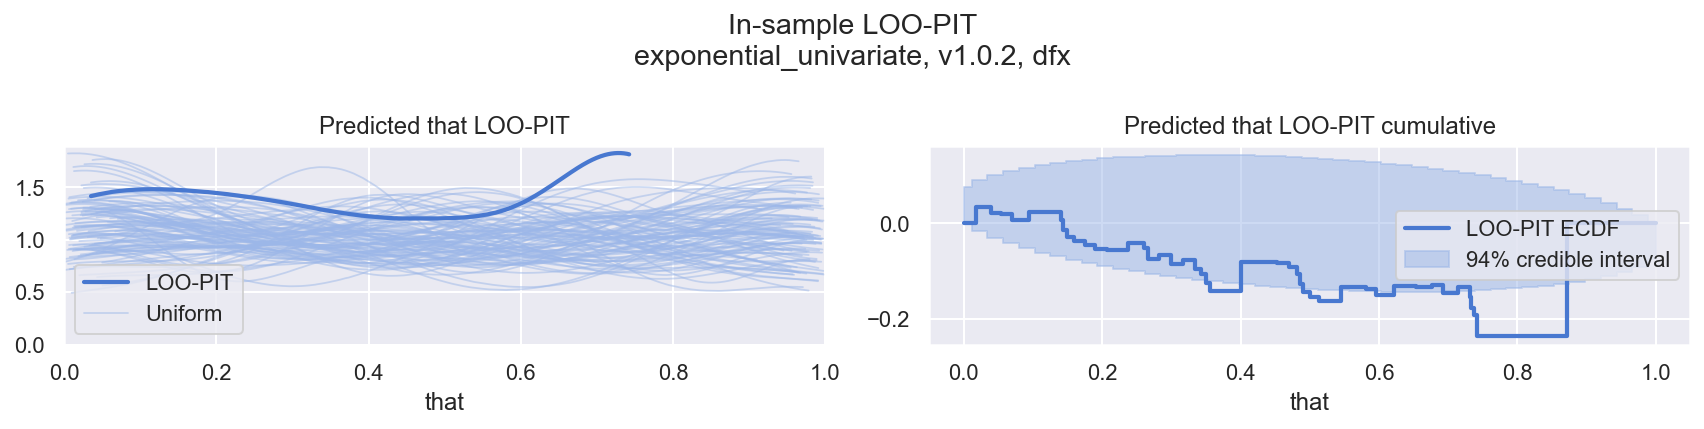

In [22]:
f = mt.plot_loo_pit(mdl_eu, data_pairs={'that': 'that'})

**Observe**

+ Again we see the relatively poor fit: slightly overdispersed and biased

## 3.6 ~~Compare Log-Likelihood vs other models~~

NOTE:

+ Nothing to compare with yet

### 3.7 Evaluate Fitted Posterior Parameters

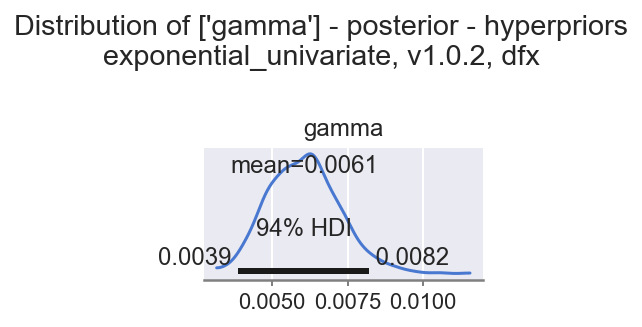

In [23]:
f = mt.facetplot_krushke(mdl=mdl_eu, group=GRP, txtadd='hyperpriors', rvs=mdl_eu.rvs_g)

**Observe**

+ Our Exponential Pooled model `mdl_eu` has a posterior value for $\mathbb{E}\hat\gamma \sim 0.006 \in [0.004, 0.008]_{HDI94}$, much tighter than the prior ($\gamma \sim 0.0067 \in [1.3e-4, 0.015]_{HDI94}$)
+ This is tighter than the `statsmodels.ExponentialFitter` with $\mathbb{E}\hat\gamma \sim 0.006 \in [0.003, 0.008]_{CI94}$
+ However, this is still an exponential model and is skewed toward the mean of
  the data, so we miss the $\gamma \sim 0.003$ as observed by the 
  directly data-transforming KM estimator

## 3.8 Forecast Survival $\hat{S}(t)$ and Expected Time-to-Event $\hat{\mathbb{E}}_{t}$

**Discussion**

Because this model is parametric, we can **forecast** Survival $\hat{S}(t)$ and Expected Time-to-Event 
  $\hat{\mathbb{E}}_{t}$ for observations in an **out-of-sample dataset**:
+ In the real-world, all we really care about is model inference (shown above) and predicting 
  Expected Time-to-Event $\hat{\mathbb{E}}_{t}$ for actual real observed new datapoints
+ However, for the purpose of greater explanation, in this Notebook we demonstrate prediction on a simplified 
  **_synthetic_ out-of-sample dataset** where:
  + Synthetic observations represent the Cartesian product of features $x$
  + Synthetic observations span the range of durations $t$
  + Then we perform a forward-pass sample-ppc (run this through the model) to estimate 
    Survival $\hat{S}(t)$ and Expected Time-to-Event $\hat{\mathbb{E}}_{t}$ for the synthetic observations
+ This lets us plot an estimated Survival curve $\hat{S}(t)$, which is a nice way to intuit the model behaviour
+ This lets us plot estimated Expected Time-to-Event $\hat{\mathbb{E}}_{t}$ for individual observations or in aggregate

**Caveats**

This is not a particularly good habit and we should be wary for multiple reasons:
+ The modelled extent of $t$ is determined by the observed $t_{max}$ in the observations, so we should be very 
  sceptical of forecasting beyond the observed $t_{max}$
+ Our observed data might be interval censored and there may be structural systematic reasons for not observing data
  at those times, so when we interpolate, we make a big assumption of parametric relationship
+ With a regression model of any greater complexity, especially with numeric features, the synthetic dataset feature
  space $x$ will explode and become impractical to synthesize. It really only works at this basic factor group level

**Further subtlety on $\hat{\mathbb{E}}_{t}$**

Our overall aggregate estimate (see $\S3.8.3$) of $\hat{\mathbb{E}}_{t}$ is dependent on $t_{max}$ and the calculating method:
+ There are two potential methods to calculate $\mathbb{{E}}_{{t}}$, and _iff_ all the observations are not right-censored 
  (and $\hat{\pi}$ is a good fit to the data) then they should be equivalent: 
  $\mathbb{{E}}_{{t}} \sim S^{{-1}}(u) \sim \int_{t=0}^{{t=\infty}} dt \ S(t)$
+ Our model directly estimates $\mathbb{{E}}_{{t}} \sim S^{{-1}}(u)$ for each observation (see the `_random()` function 
  inside the `CustomDist`)
+ However, if we also calculate the integral $\mathbb{{E}}_{{t}} \sim \int_{t=0}^{{t=t_{max}}} dt \ S(t)$ we will get a
  different aggregate distribution because (obviously) $t=t_{max} \lt t=\infty$ when the original dataset contains
  right-censored observations
+ For completeness we plot both in option A and B shown below, and prefer to use Option A, and also compare it with 
  the `km.median_survival_time_` output

> So here we create the survival curves based on a **synthetic out-of-sample dataset**

### 3.8.1 Create synthetic dataset, calc PPC and extract PPC components

In [24]:
dfs = utils.get_synthetic_df_oos(df, ndur=20)
# hack to take just half the dfs: this model ignores met so it doesn't matter
dfs = dfs.iloc[:len(dfs)//2].copy()  
dfsx = dfx_creator.get_dfx(dfs, in_sample=False)
# eda.describe(dfsx)

mdl_eu.replace_obs(obsd={'obs': dfsx}, obs_nm='dfsx')
mdl_eu.build()
f_idata = mdl_eu.sample_posterior_predictive(store_ppc=False, ppc_insample=True, var_names=mdl_eu.rvs_ppc)
dfhat = utils.get_ppc_components_as_dfm(f_idata)
eda.display_ht(dfhat)

Output()

,oid,chain,draw,shat,that,oid_sub,t
0,z000-0,0,0,1.00,18.0,z000,0
1,z000-0,0,1,1.00,267.0,z000,0
2,z000-0,0,2,1.00,217.0,z000,0
39997,z000-226,3,497,0.23,180.0,z000,226
39998,z000-226,3,498,0.21,320.0,z000,226
39999,z000-226,3,499,0.31,459.0,z000,226


'Shape: (40000, 7), Memsize 2.2 MB'

### 3.8.2 Plot estimated Survival $\hat{S}(t)$

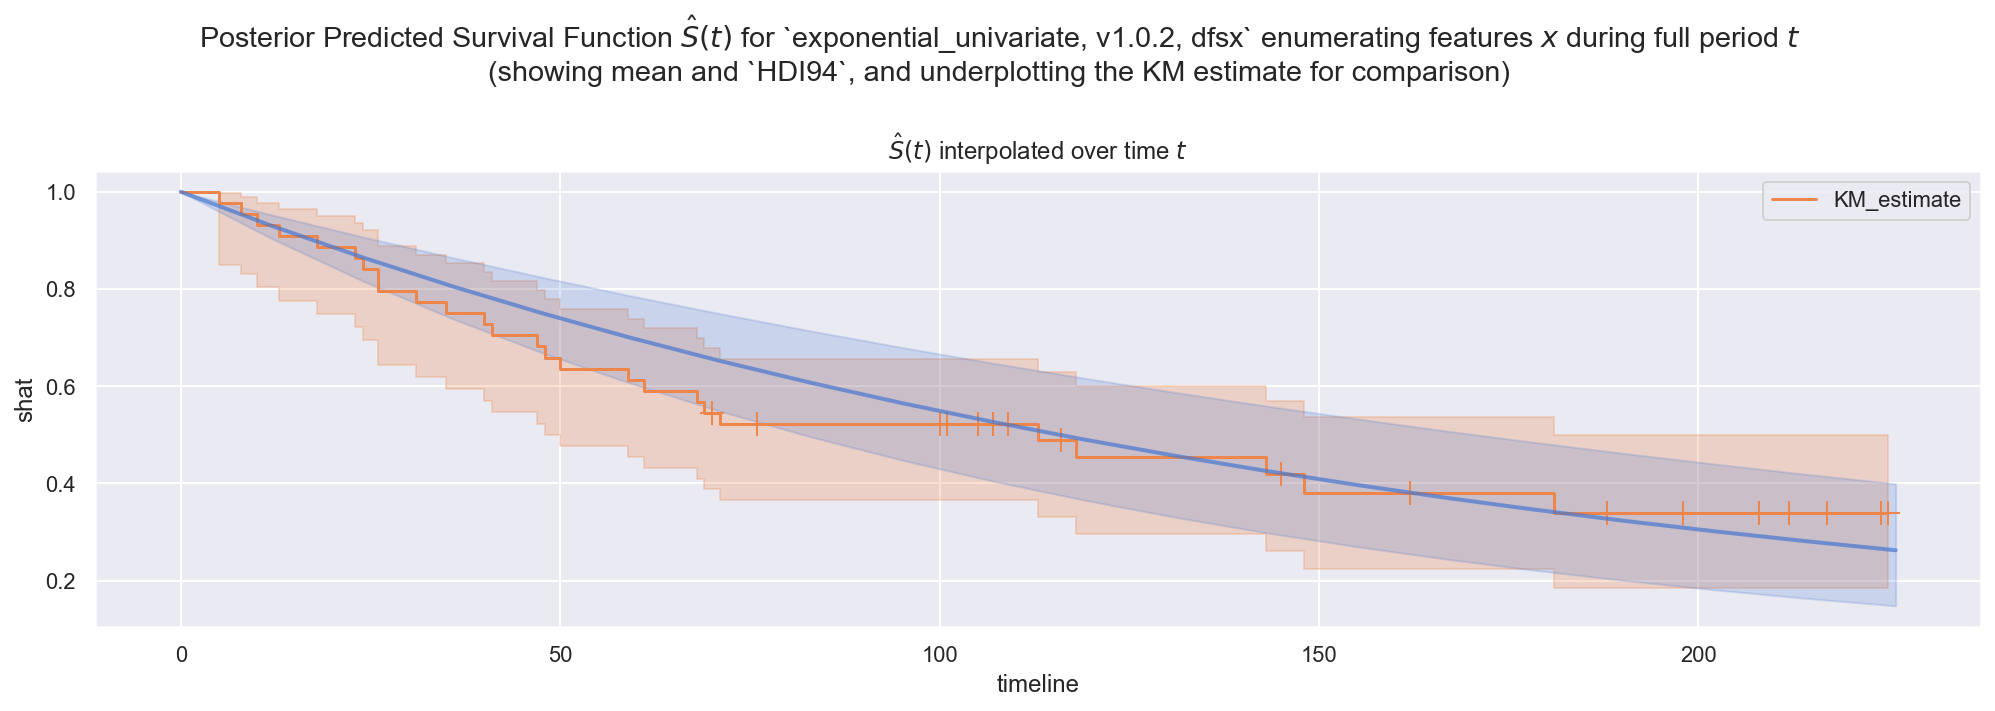

In [25]:
f, axs = plt.subplots(1, 1, figsize=(14, 5), sharex=False)
_ = km.plot_survival_function(ax=axs, show_censors=True, color='C1')
ax1 = sns.lineplot(x='t', y='shat', data=dfhat, ms=10, dashes=False, color='C0', alpha=0.7,
        legend=True, lw=2, ax=axs, estimator='mean', errorbar=('pi', 94), err_style='band')
_ = ax1.set_title('$\hat{{S}}(t)$ interpolated over time $t$')
_ = f.suptitle(f'Posterior Predicted Survival Function $\hat{{S}}(t)$ for `{mdl_eu.mdl_id}`'
            + ' enumerating features $x$ during full period $t$'
            + '\n(showing mean and `HDI94`, and underplotting the KM estimate for comparison)')
_ = f.tight_layout()
fqn = figio.write(f, fn=f'100_{mdl_eu.mdl_id}_forecast_shat')

**Observe:**

+ The parametric nature of $\hat{S}(t)$ is clear now, and the fit looks very much centered around the expected value (because it is)
+ The `HDI94` has reasonable span, and is likely moderately useful for prediction and overall group inference, though we know that we can
  (and will) improve this using the `met` feature

#### 3.8.3 Plot estimated Expected Time-to-Event $\hat{\mathbb{E}}_{t}$ (see discussion above)

Option A: Based on idealised parametric $\hat{\mathbb{E}}_{t} \sim S^{-1}(u) \sim 1/\gamma * (− \log u )$

Recap: KM: med: 113.3, mean: 117.3


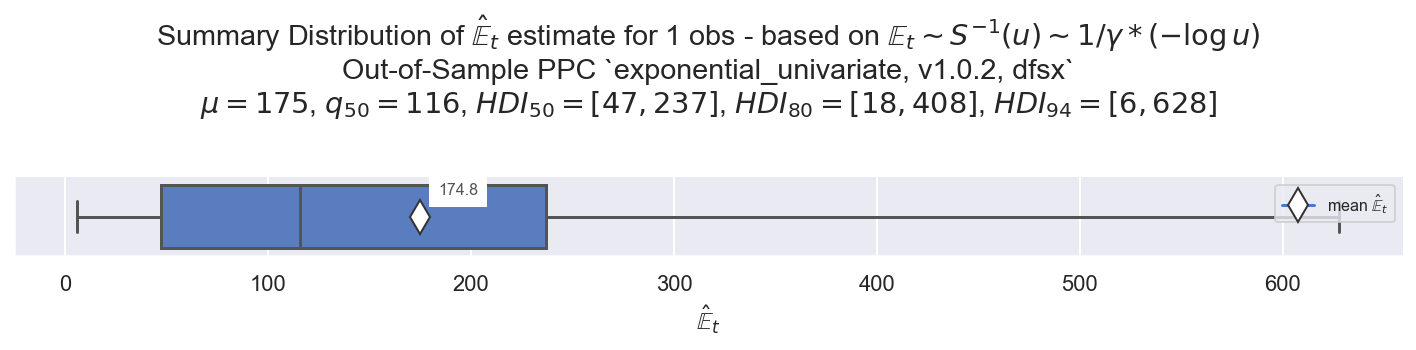

In [26]:
df_et = dfhat.loc[dfhat['t']==0].groupby(['oid_sub', 'chain', 'draw'])['that'].mean().to_frame('$\hat{\mathbb{E}}_{t}$')
f = eda.plot_estimate(df=df_et, nobs=1, yhat='$\hat{\mathbb{E}}_{t}$',
    txtadd=f'based on $\mathbb{{E}}_{{t}} \sim S^{{-1}}(u) \sim 1/\gamma * (− \log u )$\nOut-of-Sample PPC `{mdl_eu.mdl_id}`')
fqn = figio.write(f, fn=f'100_{mdl_eu.mdl_id}_forecast_et')
print(f'Recap: KM: med: {med:.1f}, mean: {mn:.1f}')

**Observe:**

+ Recap that the KM "model" (it's actually just a deterministic calculation, see `000_Intro.ipynb`) finds a 
  median survival time of $113$
+ Our model `exponential_univariate` agrees closely with a $q_{50} = 116$
+ Note this Option A method creates a long right tail (which increases the mean $\mu = 175$) because the observed data
  contains right-censoring (and $\hat{\pi}$ is not necessarily a perfect fit to the observed data)
+ So whilst the expected value is large and wide, it's not necessarily a bad estimate, and can be more useful
  

Option B: Based on observed $\hat{\mathbb{E}}_{t} \sim \int_{0}^{t_{max}} dt \ S(t)$

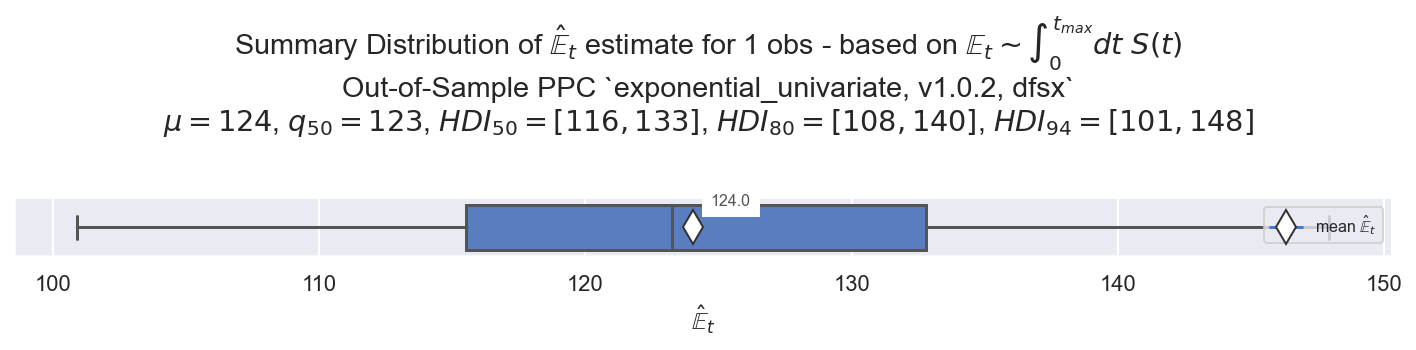

In [27]:
df_et = (dfhat.groupby(['oid_sub', 'chain', 'draw'])\
        .apply(lambda g: np.trapz(y=g['shat'], x=g['t']), include_groups=False).to_frame('$\hat{\mathbb{E}}_{t}$'))
f = eda.plot_estimate(df=df_et, nobs=1, yhat='$\hat{\mathbb{E}}_{t}$',
    txtadd=f'based on $\mathbb{{E}}_{{t}} \sim \int_{0}^{{t_{{max}}}} dt \ S(t)$\nOut-of-Sample PPC `{mdl_eu.mdl_id}`')

**Observe:**

+ This Option B estimate creates a tighter distribution because we only integrate up to $t_max$ Recap that the KM "model" 
+ Now $\mu$ and $q_{50}$ are much more similar, and the narrow distribution could be useful in e.g. a low data scenario,
  or where for we believe that $t_{max}$ is unlikely to be exceeded and we don't care about the long tail of Option A

> In both cases, we have room for improvement with a new regression model architecture that makes use of the additional
> information available in `met`

---

---

# Notes

In [28]:
%load_ext watermark
%watermark -a "jonathan.sedar@oreum.io" -udtmv -iv -p pymc,pytensor

Author: jonathan.sedar@oreum.io

Last updated: 2024-11-18 17:51:35

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.29.0

pymc    : 5.16.2
pytensor: 2.25.5

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

scipy     : 1.14.1
matplotlib: 3.9.2
oreum_core: 0.9.7
seaborn   : 0.12.2
lifelines : 0.30.0
pandas    : 2.2.3
sys       : 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25) [Clang 17.0.6 ]
pyprojroot: 0.3.0
numpy     : 1.26.4



---
**Oreum OÜ &copy; 2024**